# Description

This iPython notebook contains all code required to rerun the analysis for the paper 'Smartphone-tracked behavioural markers of depression and anxiety: Digital phenotyping in the Netherlands Study of Depression and Anxiety'. 

# Configuration

## Imports

In [3]:
import json
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pingouin as pg

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier

import rpy2.robjects as robjects

from config import make_config

## Config

In [4]:
data_dir, raw_dir, interim_dir, processed_dir, evaluation_dir, performance_dir, \
model_dir, figure_dir, descriptives_dir, features, digital_features, descriptives_dict, \
raw_data_paths = make_config()

# Data preprocessing

## Prepare data

In [6]:
def read_data(raw_dir, raw_data_paths):
    '''
    This function reads individual raw data files as pd.DataFrames and returns a list of pd.DataFrames.
    
    Parameters:
    raw_dir (str): The directory where raw data files are stored.
    raw_data_paths (list): List of file paths to raw data files.

    Returns:
    list: A list of DataFrames containing the raw data.
    '''
    
    # Read each CSV file into a DataFrame, using ';' as the separator
    df_list = [pd.read_csv(raw_dir + path, sep=';') for path in raw_data_paths]
    
    # Replace the values in the "sex" column for the third DataFrame (assume 0 for female and 1 for male)
    df_list[2]["sex"] = df_list[2].sex.replace({2: 1, 1: 0})
    
    # Select only specific columns from the third DataFrame
    df_list[2] = df_list[2][["pident", "sex", "gage", "gedu"]]
    
    return df_list

def merge_data(df_list):
    '''
    This function takes the list of pd.DataFrames as an input and returns a single merged pd.DataFrame.
    
    Parameters:
    df_list (list): A list of DataFrames to be merged.

    Returns:
    DataFrame: A single DataFrame merged on the "pident" column.
    '''
    
    # Start with the first DataFrame in the list
    df = df_list[0]
    
    # Merge the rest of the DataFrames on the "pident" column
    for single_df in df_list[1:]:
        df = pd.merge(df, single_df, on="pident")
    
    return df

def make_outcome_variables(df, ids_threshold=13, bai_threshold=9):
    '''
    This function takes the merged pd.DataFrame and creates three outcome variables: "group", "group_dep", and "group_anx". 
    "group" is used for the main analysis, while "group_dep" and "group_anx" are used for sensitivity analysis.
    
    Parameters:
    df (DataFrame): The merged DataFrame.
    ids_threshold (int): Threshold for the IDS score to define symptomatic individuals.
    bai_threshold (int): Threshold for the BAI score to define symptomatic individuals.

    Returns:
    DataFrame: The DataFrame with additional outcome variables.
    '''

    # Create a binary variable indicating whether the individual has a current depression disorder
    df["dep_status"] = df.gcidep10 > 0

    # Create a binary variable indicating whether the individual has a current anxiety disorder
    df["anx_status"] = df.ganxy21 > 0

    # Create a binary variable indicating whether the individual has either a depression or anxiety disorder
    df["psychiatric_status"] = 1 * ((df.dep_status + df.anx_status) > 0)

    # Create a binary variable indicating whether the individual has any depression or anxiety symptoms
    df["symptomatic"] = 1 * (
        (df.gids > ids_threshold) | (df.gbaiscal > bai_threshold)
    )

    # Create a categorical variable representing the individual's group: asymptomatic, subthreshold, or current diagnosis
    df["group"] = df.psychiatric_status.astype(str) + "-" + df.symptomatic.astype(str)
    
    # Replace the group codes with descriptive labels
    df = df.replace(
        {
            "0-0": "asymptomatic",
            "0-1": "subthreshold",
            "1-0": "symptomatic",
            "1-1": "symptomatic",
        }
    )

    # Create a binary variable indicating whether the individual has a depression diagnosis or symptoms but no anxiety issues
    df['group_dep'] = 1 * (((df.dep_status > 0) | (df.gids > ids_threshold)) & ((df.anx_status == 0) & (df.gbaiscal <= bai_threshold))) 

    # Create a binary variable indicating whether the individual has an anxiety diagnosis or symptoms but no depression issues
    df['group_anx'] = 1 * ((df.anx_status > 0) | (df.gbaiscal > bai_threshold)) & ((df.dep_status == 0) & (df.gids <= ids_threshold)) 
 
    return df

def rename_columns(df):
    '''
    This function renames all columns from the raw NESDA data to a more human-readable format.
    
    Parameters:
    df (DataFrame): The DataFrame with original column names.

    Returns:
    DataFrame: The DataFrame with renamed columns.
    '''
    
    # Load the dictionary for renaming columns from a JSON file
    nesda_dict = pd.read_json(raw_dir + "nesda_dictionary.json", typ="series")
    
    # Rename columns according to the dictionary
    df = df.rename(nesda_dict, axis=1)
    
    return df

def replace_spaces_by_nans(df):
    '''
    This function replaces string spaces in the data with numpy NaN values.
    
    Parameters:
    df (DataFrame): The DataFrame with potential spaces as missing values.

    Returns:
    DataFrame: The DataFrame with spaces replaced by NaN.
    '''
    
    return df.replace(" ", np.nan)

def prepare_data(raw_dir, raw_data_paths):
    '''
    This function combines all functions required to prepare the NESDA data. Returns a merged pd.DataFrame
    with human-readable columns for every feature and outcome (for both main and sensitivity analysis).
    
    Parameters:
    raw_dir (str): The directory where raw data files are stored.
    raw_data_paths (list): List of file paths to raw data files.

    Returns:
    DataFrame: A prepared and cleaned DataFrame ready for analysis.
    '''
    
    # Read the raw data into a list of DataFrames
    df_list = read_data(raw_dir, raw_data_paths)

    # Merge the DataFrames into a single DataFrame
    df = merge_data(df_list)

    # Create outcome variables
    df = make_outcome_variables(df)

    # Rename columns to be more descriptive
    df = rename_columns(df)

    # Replace spaces with NaNs for proper handling of missing data
    df = replace_spaces_by_nans(df)

    return df

def drop_pps_without_behapp(df):
    '''
    This function removes participants without any digital phenotyping data.
    
    Parameters:
    df (DataFrame): The DataFrame with participant data.

    Returns:
    DataFrame: The DataFrame with participants without digital phenotyping data removed.
    '''
    
    return df[df.has_data]

def drop_pps_with_ios(df):
    '''
    This function removes participants who do not use an Android operating system.
    
    Parameters:
    df (DataFrame): The DataFrame with participant data.

    Returns:
    DataFrame: The DataFrame with iOS participants removed.
    '''
    
    return df[df.platform == "android"].drop("platform", axis=1)

def drop_pps_without_sufficient_days(df):
    '''
    This function drops participants with less than 7 days of location and app data.
    
    Parameters:
    df (DataFrame): The DataFrame with participant data.

    Returns:
    DataFrame: The DataFrame with participants without sufficient data removed.
    '''
    
    # Create a binary variable indicating sufficient data availability
    df["sufficient_days"] = (df.unique_number_of_days_with_location_data > 6) * (
        df.unique_number_of_days_with_app_data > 6
    )
    
    return df[df.sufficient_days]

def select_columns(df):
    '''
    This function selects all relevant columns for further analysis.
    
    Parameters:
    df (DataFrame): The DataFrame with all columns.

    Returns:
    DataFrame: A DataFrame with only the relevant columns.
    '''
    
    # Extract the participant ID
    df_id = df.id

    # Select demographic features
    df_demographics = df[["demo_age", "demo_sex", "demo_edu"]]

    # Select app usage features
    df_app = df.filter(like="app")

    # Select location data features
    df_location = df.filter(like="location")

    # Select severity scores for depression and anxiety
    df_severity = df[["ids_total_score", "bai_total_score"]]

    # Select outcome variables
    df_status = df[["dep_status", "anx_status", "psychiatric_status", "group", "group_dep", "group_anx"]]

    # Concatenate all selected columns into one DataFrame
    return pd.concat([df_id, df_demographics, df_app, df_location, df_severity, df_status], axis=1)

def deal_with_subthreshold(df, approach):
    '''
    This function allows handling the subthreshold group by either excluding it, merging it with controls, or merging it with cases.
    
    Parameters:
    df (DataFrame): The DataFrame containing the group column.
    approach (str): The approach for handling the subthreshold group: "exclude", "merge-with-controls", or "merge-with-cases".

    Returns:
    DataFrame: The DataFrame with the subthreshold group handled according to the specified approach.
    '''
    
    if approach == "exclude":
        # Exclude subthreshold group from the data
        df = df[df.group != "subthreshold"]
    elif approach == "merge-with-controls":
        # Merge subthreshold group with asymptomatic controls
        df = df.replace({"subthreshold": "asymptomatic"})
    elif approach == "merge-with-cases":
        # Merge subthreshold group with current cases
        df = df.replace({"subthreshold": "symptomatic"})

    # Update the psychiatric_status column based on the new group labels
    df.psychiatric_status = df.group.replace({"asymptomatic": 0, "symptomatic": 1}).fillna(0)
    
    return df

def make_interim_data(
    raw_dir,
    raw_data_paths,
    subthreshold_approach="merge-with-cases",
    drop_ios=True,
    drop_insufficient_days=True,
    drop_columns=True
):
    '''
    This function prepares an interim dataset that can be used for visualization and description. The dataset is processed 
    through other steps of the pipeline (imputation, scaling, and feature selection) before hyperparameter tuning and model evaluation.
    
    Parameters:
    raw_dir (str): The directory where raw data files are stored.
    raw_data_paths (list): List of file paths to raw data files.
    subthreshold_approach (str, optional): Approach for handling subthreshold cases ("exclude", "merge-with-controls", "merge-with-cases"). 
                                           Default is "merge-with-cases".
    drop_ios (bool, optional): Whether to drop participants with iOS devices. Default is True.
    drop_insufficient_days (bool, optional): Whether to drop participants with insufficient days of data. Default is True.
    drop_columns (bool, optional): Whether to select and keep only relevant columns. Default is True.

    Returns:
    DataFrame: The prepared and cleaned interim dataset.
    '''

    # Prepare the data by reading, merging, and processing the raw files
    df = prepare_data(raw_dir, raw_data_paths)

    # Drop participants without any digital phenotyping data
    df = drop_pps_without_behapp(df)

    if drop_ios:
        # Drop participants using iOS devices if specified
        df = drop_pps_with_ios(df)

    if drop_insufficient_days:
        # Drop participants without sufficient data if specified
        df = drop_pps_without_sufficient_days(df)

    if drop_columns:
        # Select only relevant columns for analysis if specified
        df = select_columns(df)

    if subthreshold_approach != "":
        # Handle the subthreshold group according to the specified approach
        df = deal_with_subthreshold(df, subthreshold_approach)

    # Reset the index for the final DataFrame
    return df.reset_index(drop=True)

# Descriptives

In [7]:
def prepare_descriptives(raw_dir, raw_data_paths, grouping_var):
    '''
    This function prepares the data for creating a descriptive statistics table, grouped by a specified variable.

    It performs the following steps:
    1. Prepares the data by calling `prepare_data()` and `make_interim_data()` to handle subthreshold cases.
    2. Filters the main dataset to include only the IDs present in the interim data.
    3. Replaces specific values (-3.0, -2.0, -1.0) with NaN to clean the data.
    4. Groups the data by the specified grouping variable and aggregates using predefined statistics.
    5. Transforms the DataFrame to have variables as rows and statistics as columns.
    6. Performs various string replacements to make the variable names more readable.
    7. Returns the final DataFrame, which can be used for generating descriptive tables.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - raw_data_paths (list): List of paths to the raw data files.
    - grouping_var (str): The variable by which to group the data (e.g., 'group').

    Returns:
    - df (DataFrame): A DataFrame containing the descriptive statistics.
    '''
    df = prepare_data(raw_dir, raw_data_paths)
    df_ = make_interim_data(raw_dir, raw_data_paths, subthreshold_approach="merge-with-cases")
    df = df[df.id.isin(df_.id)]
    df = deal_with_subthreshold(df, approach="merge-with-cases")
    subgroup_count = df.group.value_counts()
    df = df.replace({-3.0: np.nan, -2.0: np.nan, -1.0: np.nan})
    df = df.groupby(grouping_var).aggregate(descriptives_dict)
    df = df.T
    df = df.reset_index()
    df = df.rename({"level_0": "variable", "level_1": "statistic"}, axis=1)
    df = df.pivot(index="variable", columns="statistic")
    df = df.fillna("-")
    df.index = df.index.str.replace("_", " ").str.capitalize()
    df.index = df.index.str.replace("month", "diagnosis in the past month")
    df.index = df.index.str.replace("6 diagnosis in the past month", "diagnosis in the past 6 months")
    df.index = df.index.str.replace("since last interview", "diagnosis in the between W7 and last interview")
    df.index = df.index.str.replace("year", "diagnosis in the past year")
    df.index = df.index.str.replace("N", "Number of")
    df.index = df.index.str.replace("App ", "App feature - ")
    df.index = df.index.str.replace("Call ", "Call feature - ")
    df.index = df.index.str.replace("Location ", "Location feature - ")
    df.index = df.index.str.replace("Number ofumber", "Number")
    df.index = df.index.str.replace("Bai", "BAI")
    df.index = df.index.str.replace("Mdd", "MDD")
    df.index = df.index.str.replace("mdd", "MDD")
    df.index = df.index.str.replace("Ids", "IDS")
    df.index = df.index.str.replace("Qids", "QIDS")
    df.index = df.index.str.replace("Gad", "GAD")
    df.index = df.index.str.replace("Dys", "Dysthymia")
    return df

def make_feature_descriptives(raw_dir, descriptives_dir):
    '''
    This function generates a descriptive statistics table for all digital phenotyping features.

    It performs the following steps:
    1. Calls `prepare_descriptives()` to prepare the data for creating the descriptives table.
    2. Filters the data to include only rows related to digital phenotyping features.
    3. Splits the variable names into feature modality and feature name for clarity.
    4. Sets the index to a combination of feature modality and feature name.
    5. Reorders the columns to include median, mean, standard deviation, minimum, and maximum.
    6. Saves the descriptive statistics to a CSV file.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - descriptives_dir (str): The directory where the descriptive statistics file will be saved.

    Returns:
    - None: The function saves the descriptive statistics to a CSV file.
    '''
    df = prepare_descriptives(raw_dir, raw_data_paths, grouping_var="group")
    df = df.filter(like="feature", axis=0).reset_index()
    df[["feature modality", "feature name"]] = df.variable.str.split(" - ", expand=True)
    df["feature name"] = df["feature name"].str.capitalize()
    df = df.set_index(["feature modality", "feature name"])
    df = df.reindex(columns=["median", "mean", "std", "min", "max"], level="statistic")
    df.to_csv(descriptives_dir + "descriptives-features.csv")

def make_diagnostic_descriptives(raw_dir, descriptives_dir):
    '''
    This function generates a descriptive statistics table for diagnostic information.

    It performs the following steps:
    1. Calls `prepare_descriptives()` to prepare the data for creating the diagnostic descriptives table.
    2. Filters and reindexes the data for different diagnostic time periods (month, 6 months, year, since last interview).
    3. Combines the filtered data into a single DataFrame.
    4. Cleans up and formats the variable names for clarity.
    5. Saves the descriptive statistics to a CSV file.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - descriptives_dir (str): The directory where the diagnostic descriptives file will be saved.

    Returns:
    - None: The function saves the diagnostic descriptive statistics to a CSV file.
    '''
    df = prepare_descriptives(raw_dir, raw_data_paths, grouping_var="group")
    df_month = df.filter(like="diagnosis in the past month", axis=0).reindex(columns=["sum"], level="statistic")
    df_6_month = df.filter(like="diagnosis in the past 6 months", axis=0).reindex(columns=["sum"], level="statistic")
    df_6_month = df_6_month[~df_6_month.index.isin(["Number of anxiety disorders diagnosis in the past 6 months", "Number of diagnoses diagnosis in the past 6 months"])]
    df_year = df.filter(like="diagnosis in the past year", axis=0).reindex(columns=["sum"], level="statistic")
    df_last_interview = df.filter(like="diagnosis in the between W7 and last interview", axis=0).reindex(columns=["sum"], level="statistic")
    df = pd.concat([df_month, df_6_month, df_year, df_last_interview], axis=0)
    df = df.astype(int)
    df = df.reset_index()
    df[["Diagnosis", "Time period"]] = df.variable.str.split(" diagnosis in the ", expand=True)
    df = df.droplevel(level=1, axis=1)
    df = df[["Time period", "Diagnosis", "asymptomatic", "symptomatic"]]
    df = df.set_index(["Time period", "Diagnosis"])
    df.to_csv(descriptives_dir + "descriptives-diagnostic.csv")

def make_self_report_descriptives(raw_dir, descriptives_dir):
    '''
    This function generates a descriptive statistics table for clinical self-reports.

    It performs the following steps:
    1. Calls `prepare_descriptives()` to prepare the data for creating the self-report descriptives table.
    2. Filters the data to include only rows related to clinical self-reports (e.g., IDS, BAI).
    3. Reorders the columns to include median, mean, standard deviation, minimum, and maximum.
    4. Saves the descriptive statistics to a CSV file.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - descriptives_dir (str): The directory where the self-report descriptives file will be saved.

    Returns:
    - None: The function saves the self-report descriptive statistics to a CSV file.
    '''
    df = prepare_descriptives(raw_dir, raw_data_paths, grouping_var="group")
    df = pd.concat([df.filter(like="IDS", axis=0), df.filter(like="BAI", axis=0)], axis=0)
    df = df.reindex(columns=["median", "mean", "std", "min", "max"], level="statistic")
    df.to_csv(descriptives_dir + "descriptives-selfreport.csv")

def make_demo_descriptives(raw_dir, descriptives_dir, raw_data_paths):
    '''
    This function generates a descriptive statistics table for demographic information.

    It performs the following steps:
    1. Prepares the data by calling `prepare_data()` and `make_interim_data()` to handle subthreshold cases.
    2. Filters the main dataset to include only the IDs present in the interim data.
    3. Deals with subthreshold cases by either merging them with other groups or excluding them.
    4. Replaces the numeric encoding of sex with human-readable labels (e.g., "Male", "Female").
    5. Aggregates the data by group to calculate counts and descriptive statistics for sex, education, and age.
    6. Combines the results into a single DataFrame and renames the columns appropriately.
    7. Saves the descriptive statistics to a CSV file.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - descriptives_dir (str): The directory where the demographic descriptives file will be saved.
    - raw_data_paths (list): List of paths to the raw data files.

    Returns:
    - None: The function saves the demographic descriptive statistics to a CSV file.
    '''
    df = prepare_data(raw_dir, raw_data_paths)
    df_ = make_interim_data(raw_dir, raw_data_paths, subthreshold_approach="merge-with-cases")
    df = df[df.id.isin(df_.id)]
    df = deal_with_subthreshold(df, approach="merge-with-cases")
    df.demo_sex = df.demo_sex.replace({0: "Male", 1: "Female"})
    
    # Aggregating the data by group for sex, education, and age
    df = pd.concat(
        [
            df.groupby("group").demo_sex.value_counts(),
            df.groupby("group").demo_edu.aggregate(["mean", "std"]),
            df.groupby("group").demo_age.aggregate(["mean", "std"]),
        ],
        axis=0,
    )
    
    df.columns = ["n", "mean", "std"]
    df.to_csv(descriptives_dir + "descriptives-demo.csv")

def make_top_feature_desciptives():
    '''
    This function computes and ranks the effect sizes of group differences for each digital phenotyping feature.
    It also calculates the mean, median, and standard deviation for these features within the groups.

    It performs the following steps:
    1. Prepares the data using `make_interim_data()` with subthreshold cases merged into the "current" group.
    2. Iterates through each feature and calculates the Cohen's d effect size for differences between groups.
    3. Collects the computed effect sizes and corresponding descriptive statistics into a DataFrame.
    4. Filters and ranks the top features based on the magnitude of the effect size.
    5. Formats the feature names for better readability and saves the top features to a CSV file.

    Returns:
    - None: The function saves the descriptive statistics of the top features to a CSV file.
    '''
    df_ = make_interim_data(raw_dir, raw_data_paths, subthreshold_approach="merge-with-cases")
    effect_sizes = pd.DataFrame()

    # Iterating over each feature and calculating effect sizes between groups
    for var in df_.columns[6:]:
        for group1 in ["asymptomatic", "symptomatic"]:
            for group2 in ["asymptomatic", "symptomatic"]:
                try:
                    cohens_d = pg.compute_effsize(
                        df_[var][df_.group == group1].dropna(),
                        df_[var][df_.group == group2].dropna(),
                    )
                    effect_sizes = pd.concat(
                        [
                            effect_sizes,
                            pd.DataFrame(
                                {
                                    "feature": var,
                                    "group1": group1,
                                    "group2": group2,
                                    "mean1": df_[var][df_.group == group1].mean(),
                                    "median1": df_[var][df_.group == group1].median(),
                                    "sd1": df_[var][df_.group == group1].std(),
                                    "mean2": df_[var][df_.group == group2].mean(),
                                    "median2": df_[var][df_.group == group2].median(),
                                    "sd2": df_[var][df_.group == group2].std(),
                                    "d": cohens_d,
                                },
                                index=[0],
                            ),
                        ]
                    )
                except:
                    pass

    # Cleaning and sorting the effect sizes
    effect_sizes = effect_sizes.replace({np.inf: np.nan, -np.inf: np.nan}).dropna()
    effect_sizes["d"] = effect_sizes.d.abs()

    # Filtering for app and location features, and selecting the top features
    app_es = effect_sizes.set_index("feature").filter(like="app_", axis=0)
    loc_es = effect_sizes.set_index("feature").filter(like="location_", axis=0)
    app_es = app_es.sort_values(by="d", ascending=False).iloc[:20, :].round(2)
    loc_es = loc_es.sort_values(by="d", ascending=False).iloc[:20, :].round(2)

    effect_size_df = pd.concat([app_es, loc_es], axis=0).reset_index()
    effect_size_df.feature = (
        effect_size_df.feature.str.replace("_", " ")
        .str.split(" ")
        .apply(lambda x: x[1:])
        .str.join(" ")
        .str.capitalize()
    )
    effect_size_df[effect_size_df.group1 == "asymptomatic"].to_csv(
        descriptives_dir + "descriptives-top-features.csv"
    )

def make_ridgelines_plot(raw_dir, raw_data_paths, digital_features):
    '''
    This function prepares the data and generates a ridgeline plot to visualize the distribution of digital phenotyping features.

    It performs the following steps:
    1. Prepares the data using `make_interim_data()` and fills missing values for app and location features.
    2. Scales the digital phenotyping features using MinMaxScaler.
    3. Reshapes the data into a long format suitable for plotting.
    4. Adds labels and groups for the features, reorders the variables based on their mean value.
    5. Saves the prepared data to a CSV file and calls an external R script to generate the ridgeline plot.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - raw_data_paths (list): List of paths to the raw data files.
    - digital_features (list): List of digital phenotyping features to include in the plot.

    Returns:
    - None: The function saves the prepared data to a CSV file and generates the plot using an R script.
    '''
    df = make_interim_data(raw_dir, raw_data_paths)

    # Filling missing values for app and location features
    df[df.filter(like='app').columns] = df.filter(like='app').fillna(0)
    df.location_total_number_of_nightly_staypoints_excluding_home = df.location_total_number_of_nightly_staypoints_excluding_home.fillna(0)
  
    # Scaling the digital features
    scaler = MinMaxScaler()
    df[digital_features] = scaler.fit_transform(df[digital_features])

    # Reshaping the data for plotting
    digital_features.append('group')
    df = df[digital_features].melt(id_vars='group')
    df.loc[:,'feature_group'] = df.variable.str.split('_').str[0]
    df.group = df.group.replace({'symptomatic':'Symptomatic','asymptomatic':'Asymptomatic'})
    df.feature_group = df.feature_group.replace({'app':'Smartphone app use','location':'Location'})
    df.variable = df.variable.str.split('_').str[1:].str.join(' ').str.capitalize().replace('minutes','(minutes)',regex=True).replace('hours','(hours)',regex=True).replace('kilometers','(kilometers)',regex=True)

    # Reordering the variables based on their mean value
    df = pd.merge(df, df.groupby('variable').value.mean().sort_values(ascending=False), on='variable', suffixes=('_feature','_mean'))
    df = df.sort_values(by='value_mean', ascending=False)
    df.to_csv('ridgelines-df.csv', index=False)

    # Calling an R script to generate the ridgeline plot
    robjects.r('source("ridgelines-data-visualisation.R")')

def make_missingness_barplot():
    '''
    This function generates and saves a bar plot to visualize the number of missing values per feature.

    It performs the following steps:
    1. Prepares the data using `make_interim_data()` and fills missing values for app and location features.
    2. Calculates the number of missing values per feature and formats the feature names.
    3. Generates a horizontal bar plot showing the number of missing values for each feature.
    4. Saves the plot to a PNG file.

    Returns:
    - None: The function saves the missingness bar plot to a PNG file.
    '''
    df = make_interim_data(raw_dir, raw_data_paths, subthreshold_approach='merge-with-cases')

    # Filling missing values for app and location features
    df[df.filter(like='app').columns] = df.filter(like='app').fillna(0)
    df.location_total_number_of_nightly_staypoints_excluding_home = df.location_total_number_of_nightly_staypoints_excluding_home.fillna(0)
    
    # Calculating the number of missing values per feature
    df = df[digital_features].isna().sum()[df.isna().sum() != 0].reset_index()
    
    # Formatting the feature names
    df.columns = ['Feature', 'Number of missing values']
    df.Feature = df.Feature.str.capitalize().str.split('_').str.join(' ').str.replace('minutes', '(minutes)').str.replace('kilometers', '(kilometers)').str.replace('hours','(hours)')
    
    # Generating the bar plot
    sns.barplot(data=df, x='Number of missing values', y='Feature', color='black')

    plt.tight_layout()
    
    # Saving the plot to a file
    plt.savefig(figure_dir + 'missingness.png')
    plt.clf()

def run_all_descriptives_functions(raw_dir, raw_data_paths, descriptives_dir, digital_features):
    '''
    This function orchestrates the generation of all descriptives tables and figures by calling the relevant functions.

    It performs the following steps:
    1. Calls `make_demo_descriptives()` to generate demographic descriptives.
    2. Calls `make_diagnostic_descriptives()` to generate descriptives for diagnostic information.
    3. Calls `make_self_report_descriptives()` to generate descriptives for clinical self-reports.
    4. Calls `make_feature_descriptives()` to generate descriptives for digital phenotyping features.
    5. Calls `make_top_feature_desciptives()` to compute effect sizes and rank the top features.
    6. Calls `make_ridgelines_plot()` to prepare data and generate ridgeline plots.
    7. Calls `make_missingness_barplot()` to generate a bar plot of missing values.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - raw_data_paths (list): List of paths to the raw data files.
    - descriptives_dir (str): The directory where the descriptive statistics files will be saved.
    - digital_features (list): List of digital phenotyping features to include in the plots.

    Returns:
    - None: The function orchestrates the generation and saving of various descriptives outputs.
    '''
    # Generating all descriptives tables and figures
    make_demo_descriptives(raw_dir, descriptives_dir, raw_data_paths)
    make_diagnostic_descriptives(raw_dir, descriptives_dir)
    make_self_report_descriptives(raw_dir, descriptives_dir)
    make_feature_descriptives(raw_dir, descriptives_dir)
    make_top_feature_desciptives()
    make_ridgelines_plot(raw_dir, raw_data_paths, digital_features)
    make_missingness_barplot()

run_all_descriptives_functions(raw_dir, raw_data_paths, descriptives_dir, digital_features)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_op

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.4     ✔ readr   2.1.5
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ ggplot2 3.5.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Picking joint bandwidth of 0.034

R[write to console]: Picking joint bandwidth of 0.0251

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: `fct_reorder()` removing 119 missing values.
ℹ Use `.na_rm = TRUE` to silence this message.
ℹ Use `.na_rm = FALSE` to preserve NAs. 

R[write to console]: 2: Removed 124 rows containing non-finite outside the scale range
(`stat_density_ridges()`). 

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


<Figure size 640x480 with 0 Axes>

# Make dataset

## Data splitting

In [7]:
def split_cols(df, target, features):
    '''
    This function splits a DataFrame into three separate DataFrames: one for the target variable (y), one for the features (X),
    and one for the IDs.

    It performs the following steps:
    1. Extracts the target column (y) from the DataFrame.
    2. Extracts the specified feature columns (X) from the DataFrame.
    3. Extracts the "id" column from the DataFrame.

    Parameters:
    - df (DataFrame): The input DataFrame containing all the data.
    - target (str): The name of the target column.
    - features (list): A list of column names to be used as features.

    Returns:
    - X (DataFrame): The DataFrame containing the selected features.
    - y (Series): The Series containing the target variable.
    - id (Series): The Series containing the ID values.
    '''
    y = df[target]
    X = df[features]
    id = df["id"]
    return X, y, id


def write_to_file(df, name):
    '''
    This function writes a DataFrame to a CSV file without including the index.

    Parameters:
    - df (DataFrame): The DataFrame to be written to a file.
    - name (str): The path and filename where the DataFrame should be saved.

    Returns:
    - None: The function writes the DataFrame to a CSV file.
    '''
    df.to_csv(name, index=False)


def write_all_to_file(
    X_train,
    X_test,
    y_train,
    y_test,
    id_train,
    id_test,
    interim_dir,
    processed_dir,
    fold,
):
    '''
    This function writes multiple DataFrames (training and testing data for features, target, and IDs) to corresponding CSV files.

    It performs the following steps:
    1. Writes the training features, target, and IDs to the interim and processed directories.
    2. Writes the testing features, target, and IDs to the interim and processed directories.

    Parameters:
    - X_train (DataFrame): The training features.
    - X_test (DataFrame): The testing features.
    - y_train (Series): The training target.
    - y_test (Series): The testing target.
    - id_train (Series): The training IDs.
    - id_test (Series): The testing IDs.
    - interim_dir (str): The directory where interim training and testing data will be saved.
    - processed_dir (str): The directory where processed training and testing IDs will be saved.
    - fold (int): The fold number for cross-validation.

    Returns:
    - None: The function writes all the DataFrames to their respective CSV files.
    '''
    write_to_file(X_train, interim_dir + "X_train_" + str(fold) + ".csv")
    write_to_file(y_train, interim_dir + "y_train_" + str(fold) + ".csv")
    write_to_file(id_train, processed_dir + "id_train_" + str(fold) + ".csv")
    write_to_file(X_test, interim_dir + "X_test_" + str(fold) + ".csv")
    write_to_file(y_test, interim_dir + "y_test_" + str(fold) + ".csv")
    write_to_file(id_test, processed_dir + "id_test_" + str(fold) + ".csv")

def get_features_df(
    raw_dir, interim_dir, processed_dir, features, target, subthreshold_approach
):
    '''
    This function prepares and returns a DataFrame containing the selected features for further analysis.

    It performs the following steps:
    1. Prepares the data using `make_interim_data()` with the specified subthreshold approach.
    2. Splits the DataFrame into features (X), target (y), and IDs using the `split_cols()` function.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - interim_dir (str): The directory where interim data is stored.
    - processed_dir (str): The directory where processed data is stored.
    - features (list): A list of column names to be used as features.
    - target (str): The name of the target column.
    - subthreshold_approach (str): The approach for handling subthreshold cases.

    Returns:
    - X (DataFrame): A DataFrame containing the selected features.
    '''
    df = make_interim_data(raw_dir, subthreshold_approach=subthreshold_approach)
    X, y, id = split_cols(df, target, features)
    return X

def make_train_test_splits(
    raw_dir, interim_dir, processed_dir, features, target, subthreshold_approach
):
    '''
    This function generates and saves 5 stratified train-test splits for cross-validation.

    It performs the following steps:
    1. Prepares the data using `make_interim_data()` and splits it into features (X), target (y), and IDs.
    2. Uses StratifiedKFold to split the data into 5 train-test pairs, ensuring stratification based on the target variable.
    3. For each fold, it writes the training and testing data (features, target, IDs) to the appropriate directories.

    Parameters:
    - raw_dir (str): The directory containing the raw data.
    - interim_dir (str): The directory where interim data is stored.
    - processed_dir (str): The directory where processed data is stored.
    - features (list): A list of column names to be used as features.
    - target (str): The name of the target column.
    - subthreshold_approach (str): The approach for handling subthreshold cases.

    Returns:
    - None: The function saves the train-test splits to the specified directories.
    '''
    df = make_interim_data(raw_dir, raw_data_paths, subthreshold_approach=subthreshold_approach)

    X, y, id = split_cols(df, target, features)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train = X.loc[train_index, :]
        X_test = X.loc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        id_train = id[train_index]
        id_test = id[test_index]

        write_all_to_file(
            X_train,
            X_test,
            y_train,
            y_test,
            id_train,
            id_test,
            interim_dir,
            processed_dir,
            fold
        )


args = pd.read_json("config.json")

make_train_test_splits(raw_dir, interim_dir, processed_dir, **args.loc['main', :].to_dict())

## Imputation

In [8]:
def read_data(train_file, test_file):
    '''Helper function to read multiple files at once.
    
    This function reads training and testing datasets from CSV files.

    It performs the following steps:
    1. Reads the training data from the specified file path.
    2. Reads the testing data from the specified file path.
    3. Returns both datasets as pandas DataFrames.

    Parameters:
    - train_file (str): Path to the training data CSV file.
    - test_file (str): Path to the testing data CSV file.

    Returns:
    - X_train (DataFrame): The training dataset.
    - X_test (DataFrame): The testing dataset.
    '''
    X_train = pd.read_csv(train_file)
    X_test = pd.read_csv(test_file)
    return X_train, X_test


def write_to_file(df, name):
    '''Helper function to write a DataFrame to a CSV file.
    
    This function saves a pandas DataFrame to a specified file without including the index.

    It performs the following steps:
    1. Saves the DataFrame to a CSV file at the specified location.

    Parameters:
    - df (DataFrame): The DataFrame to be saved.
    - name (str): The file path and name where the DataFrame should be saved.

    Returns:
    - None: The function writes the DataFrame to a file.
    '''
    df.to_csv(name, index=False)


def read_features(dir, fold):
    '''Helper function to read train and test features for a single fold at once.
    
    This function reads the training and testing datasets for a specific cross-validation fold from CSV files.

    It performs the following steps:
    1. Constructs the file paths for the training and testing datasets based on the specified fold number.
    2. Reads the datasets using the `read_data` helper function.
    3. Returns the training and testing datasets along with their file paths.

    Parameters:
    - dir (str): Directory where the interim data is stored.
    - fold (int): The fold number (e.g., 0, 1, 2, 3, or 4).

    Returns:
    - X_train (DataFrame): The training dataset for the specified fold.
    - X_test (DataFrame): The testing dataset for the specified fold.
    - X_train_name (str): The file path of the training dataset.
    - X_test_name (str): The file path of the testing dataset.
    '''
    X_train_name = interim_dir + "X_train_" + str(fold) + ".csv"
    X_test_name = interim_dir + "X_test_" + str(fold) + ".csv"
    X_train, X_test = read_data(X_train_name, X_test_name)
    return X_train, X_test, X_train_name, X_test_name


def feature_imputation(interim_dir, skip=False):
    '''Function imputes missing values in the train and test datasets. 
    
    This function performs imputation on missing values in the training and testing datasets for multiple folds.
    Features that should be zero when missing are imputed with zero. Mean imputation can be optionally skipped
    for experimentation with other imputation approaches.

    It performs the following steps:
    1. Iterates over each cross-validation fold (0 to 4).
    2. Reads the training and testing datasets for the fold using the `read_features` helper function.
    3. Drops columns that have all missing values.
    4. Imputes missing values in app-related features and location staypoints with zero.
    5. If `skip` is False, imputes remaining missing values with the mean of the respective feature in the training dataset.
    6. Saves the imputed datasets back to their respective files.

    Parameters:
    - interim_dir (str): Directory where the interim data is stored.
    - skip (bool): If True, skips mean imputation. Default is False.

    Returns:
    - None: The function saves the imputed datasets to the specified file paths.
    '''
    for fold in range(5):

        X_train, X_test, X_train_name, X_test_name = read_features(interim_dir, fold)

        # Drop columns that have all missing values
        X_train = X_train.dropna(how="all", axis=1)

        # Impute app-related features and location staypoints with zero
        X_train[X_train.filter(like="apps").fillna(0).columns] = X_train.filter(
            like="apps"
        ).fillna(0)
        X_test[X_test.filter(like="apps").fillna(0).columns] = X_test.filter(
            like="apps"
        ).fillna(0)
        X_train.location_total_number_of_nightly_staypoints_excluding_home = X_train.location_total_number_of_nightly_staypoints_excluding_home.fillna(0)
        X_test.location_total_number_of_nightly_staypoints_excluding_home = X_test.location_total_number_of_nightly_staypoints_excluding_home.fillna(0)
    
        # Perform mean imputation unless skipped
        if not skip:
            X_train = X_train.select_dtypes(["int", "int64", "float", "float64"])
            X_test = X_test[X_train.columns]
            X_train = X_train.fillna(X_train.mean().to_dict())
            X_test = X_test.fillna(X_train.mean().to_dict())

        # Save the imputed datasets back to the files
        write_to_file(X_train, X_train_name)
        write_to_file(X_test, X_test_name)

feature_imputation(interim_dir)

## Scale features

In [9]:
def scale(interim_dir, fold):
    """
    This function applies min-max scaling to the train/test data of a single data split.

    Parameters:
    interim_dir (str): The directory where the interim data files are stored.
    fold (int): The fold number to read and scale the data for.

    Returns:
    tuple: Contains the following elements:
        - X_train (DataFrame): Scaled training data.
        - X_test (DataFrame): Scaled test data.
        - X_train_name (DataFrame): Metadata or names associated with the training data.
        - X_test_name (DataFrame): Metadata or names associated with the test data.
    """

    # Read features and names for the specified fold
    X_train, X_test, X_train_name, X_test_name = read_features(interim_dir, fold)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform it
    X_train = scaler.fit_transform(X_train)

    # Convert the scaled training data back to a DataFrame with the correct feature names
    X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())

    # Transform the test data using the same scaler and convert it to a DataFrame
    X_test = pd.DataFrame(
        scaler.transform(X_test), columns=scaler.get_feature_names_out()
    )

    return X_train, X_test, X_train_name, X_test_name


def scale_and_write_to_file(interim_dir):
    """
    This function applies min-max scaling to all data splits and writes the scaled data to files.

    Parameters:
    interim_dir (str): The directory where the interim data files are stored.
    """

    # Loop over 5 folds to scale and save the data for each fold
    for fold in range(5):

        # Apply scaling to the current fold
        X_train, X_test, X_train_name, X_test_name = scale(interim_dir, fold)

        # Write the scaled training data to a file
        write_to_file(X_train, X_train_name)

        # Write the scaled test data to a file
        write_to_file(X_test, X_test_name)

# Execute the scaling and writing process for all folds
scale_and_write_to_file(interim_dir)

## Select features

In [10]:
def read_data(input_dir, fold):
    """
    This function reads and returns different parts of the data for a single fold.

    Parameters:
    input_dir (str): The directory where the data files are stored.
    fold (int): The fold number to read the data for.

    Returns:
    tuple: Contains the following elements:
        - X_train (DataFrame): Training data features.
        - X_test (DataFrame): Test data features.
        - X_train_demo (DataFrame): Training data demographic features.
        - X_test_demo (DataFrame): Test data demographic features.
        - y_train (ndarray): Training data labels.
        - y_test (ndarray): Test data labels.
    """

    # Read the training data for the specified fold
    X_train = pd.read_csv(input_dir + "X_train_" + str(fold) + ".csv")
    
    # Filter out demographic features from the training data
    X_train_demo = X_train.filter(like="demo_")
    
    # Read the test data for the specified fold
    X_test = pd.read_csv(input_dir + "X_test_" + str(fold) + ".csv")
    
    # Filter out demographic features from the test data
    X_test_demo = X_test.filter(like="demo_")
    
    # Read the training labels and convert them to a flat numpy array
    y_train = pd.read_csv(input_dir + "y_train_" + str(fold) + ".csv").to_numpy().ravel()
    
    # Read the test labels and convert them to a flat numpy array
    y_test = pd.read_csv(input_dir + "y_test_" + str(fold) + ".csv").to_numpy().ravel()
    
    return X_train, X_test, X_train_demo, X_test_demo, y_train, y_test

def boruta_single_df(X, y, perc=100):
    """
    This function applies the Boruta feature selection algorithm to a single DataFrame.

    Parameters:
    X (DataFrame): The input features.
    y (ndarray): The target labels.
    perc (int, optional): The percentage of features to consider in each iteration. Default is 100.

    Returns:
    DataFrame: The DataFrame containing only the selected features.
    """

    # Initialize the RandomForestClassifier model with balanced class weights
    model = RandomForestClassifier(max_depth=5, class_weight="balanced", n_jobs=-1)
    
    # Initialize the Boruta feature selector with the given model and parameters
    boruta_selector = BorutaPy(
        model, n_estimators="auto", perc=perc, random_state=42, max_iter=200
    )

    # Fit the Boruta selector on the input data
    boruta_selector.fit(X, y)

    # Get the selected features' column names
    selected_features = X.columns[boruta_selector.support_]

    # Keep only the selected features in the DataFrame
    X = X[selected_features]

    return X

def boruta_multiple_dfs(input_dir, output_dir):
    """
    This function applies the Boruta feature selection across multiple folds and aggregates the selected features.

    Parameters:
    input_dir (str): The directory where the input data files are stored.
    output_dir (str): The directory where the output files will be saved (not used in this code).

    Returns:
    list: A list of selected features across all folds.
    """

    # Initialize an empty list to store selected features from all folds
    feature_list = []
    
    # Iterate over a range of 5 folds
    for fold in range(5):

        # Read the data for the current fold
        X_train, X_test, X_train_demo, X_test_demo, y_train, y_test = read_data(
            input_dir, fold
        )

        # Apply Boruta feature selection on the training data
        X_train = boruta_single_df(X_train, y_train, perc=80)

        # Extend the feature list with the selected features' names
        feature_list.extend(X_train.columns.tolist())

    return feature_list

# Apply Boruta feature selection across multiple folds and get the list of selected features
feature_list = boruta_multiple_dfs(interim_dir, processed_dir)

# Count the occurrence of each feature across the folds
pd.Series(feature_list).value_counts()

location_total_number_of_trajectories                       5
location_total_time_spent_outside_including_travel_hours    3
app_number_of_apps_used                                     3
location_mean_time_spent_stationary_hours                   3
location_standard_deviation_time_travelled_hours            1
location_percentage_of_staypoints_visited_once              1
location_total_distance_travelled_kilometers                1
app_duration_opened_all_apps_minutes_at_night               1
app_mean_duration_opened_communication_apps_minutes         1
location_mean_time_travelled_hours                          1
location_total_time_spent_stationary_hours                  1
Name: count, dtype: int64

In [11]:
def select_feature_multiple_dfs(input_dir, output_dir):
    '''
    This function processes training and test datasets across multiple data folds, specifically selecting and 
    saving a subset of features for each fold. The process includes the following steps:

    1. Iterates through a predefined number of data folds (in this case, 5 folds).
    2. For each fold, reads the training and test datasets along with their corresponding demographic data and labels.
    3. Selects a subset of features from the training and test datasets, specifically combining demographic data 
       with the 'location_total_number_of_trajectories' feature.
    4. Constructs file names for saving the processed datasets (both features and labels) for each fold.
    5. Saves the processed training and test datasets, as well as their corresponding labels, to the specified output directory.

    Parameters:
    - input_dir (str): The directory where the input data files are stored.
    - output_dir (str): The directory where the processed data files will be saved.
    
    Returns:
    - None: The function saves the processed datasets and labels as CSV files in the specified output directory.
    '''
    
    # Loop over the 5 data folds
    for fold in range(5):

        # Read the data for the current fold (training and test features, demographics, and labels)
        X_train, X_test, X_train_demo, X_test_demo, y_train, y_test = read_data(
            input_dir, fold
        )

        # Select and combine the demographic data and the 'location_total_number_of_trajectories' feature for the training set
        X_train = pd.concat(
            [X_train_demo, X_train['location_total_number_of_trajectories']], axis=1
        )

        # Select and combine the demographic data and the 'location_total_number_of_trajectories' feature for the test set
        X_test = pd.concat(
            [X_test_demo, X_test['location_total_number_of_trajectories']], axis=1
        )

        # Construct the file names for saving the processed training features and labels
        X_train_name = output_dir + "X_train_" + str(fold) + ".csv"
        y_train_name = output_dir + "y_train_" + str(fold) + ".csv"

        # Construct the file names for saving the processed test features and labels
        X_test_name = output_dir + "X_test_" + str(fold) + ".csv"
        y_test_name = output_dir + "y_test_" + str(fold) + ".csv"

        # Save the processed training features to a CSV file
        write_to_file(X_train, X_train_name)

        # Save the training labels to a CSV file
        write_to_file(pd.DataFrame(y_train), y_train_name)

        # Save the processed test features to a CSV file
        write_to_file(X_test, X_test_name)

        # Save the test labels to a CSV file
        write_to_file(pd.DataFrame(y_test), y_test_name)

# Execute the function to process and save features for all data folds
select_feature_multiple_dfs(interim_dir, processed_dir)

# Supervised learning

## Model training

In [12]:
from sklearn.metrics import make_scorer

def build_model(model_type):
    '''
    This function builds and configures a machine learning model based on the specified model type.
    It performs the following steps:

    1. Sets up a Stratified K-Fold cross-validation scheme to ensure balanced class representation across splits.
    2. Defines a set of hyperparameters to be tuned during model training, specific to the type of model.
    3. Initializes the model with appropriate settings (e.g., logistic regression, random forest, or dummy classifier).
    4. Wraps the model in a `GridSearchCV` object to perform an exhaustive search over the specified hyperparameters.
    5. Creates a pipeline that includes Min-Max scaling followed by the model with hyperparameter tuning.

    Parameters:
    - model_type (str): The type of model to build, which can be "lr" (logistic regression), "rf" (random forest), or "dummy" (baseline model).

    Returns:
    - Pipeline: A scikit-learn pipeline object that includes data scaling and the model wrapped in a grid search for hyperparameter tuning.
    '''
    
    # Define a stratified K-Fold cross-validation strategy with 10 splits
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    if model_type == "lr":
        # Define hyperparameters for Logistic Regression
        parameters = {
            "penalty": ["elasticnet"],
            "C": np.logspace(-3, 3, num=6),
            "l1_ratio": np.arange(0.01, 1, 0.1),
            "solver": ["saga"],
        }

        # Initialize Logistic Regression model with balanced class weights
        model = LogisticRegression(
            max_iter=10000, class_weight="balanced", random_state=42
        )
  
    elif model_type == "rf":
        # Define hyperparameters for Random Forest
        parameters = {
            "max_depth": [5, 10, 15, 20],
            "max_features": ["sqrt", "log2"],
            "min_samples_leaf": [5, 10, 15, 20],
            "n_estimators": np.arange(100, 600, 100),
        }

        # Initialize Random Forest model with balanced class weights
        model = RandomForestClassifier(random_state=42, class_weight="balanced")
     
    elif model_type == 'dummy':
        # Define parameters for Dummy Classifier (baseline model)
        parameters = {'strategy': ["uniform"]}
        
        # Initialize Dummy Classifier
        model = DummyClassifier(random_state=42)
 
    # Wrap the model in GridSearchCV to perform hyperparameter tuning
    model = GridSearchCV(
        model, parameters, scoring='roc_auc', verbose=4, n_jobs=-1, cv=cv
    )
    
    # Create a pipeline that scales the data and then applies the model
    model = make_pipeline(MinMaxScaler(), model)

    return model


def fit_model(model, X, y):
    '''
    This function fits the provided model to the training data.

    Parameters:
    - model (Pipeline): The scikit-learn pipeline object that includes data scaling and model training.
    - X (DataFrame): The feature matrix for training.
    - y (Series or ndarray): The target labels for training.

    Returns:
    - Pipeline: The trained model.
    '''
    return model.fit(X, y)


def save_model(model, model_dir, model_type, modality, fold):
    '''
    This function saves the trained model to a specified directory in a serialized format (pickle).

    Parameters:
    - model (Pipeline): The trained scikit-learn pipeline object.
    - model_dir (str): The directory where the model will be saved.
    - model_type (str): The type of model (e.g., "lr", "rf", "dummy").
    - modality (str): The modality or feature set used for training (e.g., "demo", "dpd", "all").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - None: The function saves the model as a .pkl file in the specified directory.
    '''
    
    # Create the filename for the model based on model type, modality, and fold
    file_path = model_dir + model_type + "_" + modality + "_" + str(fold) + ".pkl"
    
    # Save the model as a pickle file
    with open(file_path, "wb") as f:
        pickle.dump(model, f)


def train_models(processed_dir, model_dir, model_types, modalities):
    '''
    This function orchestrates the training of multiple models across different modalities and cross-validation folds.
    It performs the following steps:

    1. Iterates over each fold in the cross-validation scheme.
    2. Reads the processed training data and labels for the current fold.
    3. For each model type (e.g., logistic regression, random forest, dummy classifier), and for each modality 
       (e.g., demographic data, digital phenotyping data, or all data), the function builds, fits, and saves the model.
    4. Depending on the modality, it selects appropriate features for training.

    Parameters:
    - processed_dir (str): The directory where the processed data files are stored.
    - model_dir (str): The directory where the trained models will be saved.
    - model_types (list): A list of model types to be trained (e.g., ["dummy", "lr", "rf"]).
    - modalities (list): A list of modalities to be used for training (e.g., ["demo", "dpd", "all"]).
    
    Returns:
    - None: The function trains and saves models for all specified combinations of model types and modalities.
    '''
    
    # Loop over the 5 cross-validation folds
    for fold in range(5):

        # Read the training features and labels for the current fold
        X = pd.read_csv(processed_dir + "X_train_" + str(fold) + ".csv")
        y = pd.read_csv(processed_dir + "y_train_" + str(fold) + ".csv").squeeze()

        # Loop over each model type to be trained
        for model_type in model_types:

            # Loop over each modality to be used for training
            for modality in modalities:

                # Build the model based on the specified type
                model = build_model(model_type)

                if modality == "dpd":
                    # Exclude demographic features for the "dpd" modality
                    X_ = X[X.columns[~X.columns.isin(X.filter(like="demo").columns)]]
                    # Fit the model using the selected features
                    model = fit_model(model, X_, y)

                elif modality == "demo":
                    # Fit the model using only demographic features
                    model = fit_model(model, X.filter(like=modality), y)

                else:
                    # Fit the model using all features
                    model = fit_model(model, X, y)

                # Save the trained model to the specified directory
                save_model(model, model_dir, model_type, modality, fold)


# General set-up for training models
model_types = ["dummy", "lr", "rf"]  # Model types: Dummy, Logistic Regression, Random Forest
modalities = ["demo", "dpd", "all"]  # Modalities: Demographic data, Digital phenotyping data, All data

# Train and save models for all specified combinations of model types and modalities
train_models(processed_dir, model_dir, model_types, modalities)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 160 candidates, totalling 1600 f

In [13]:
def unpickle(file):
    '''
    This function loads a serialized Python object from a pickle file.
    
    Parameters:
    - file (str): The path to the pickle file that contains the serialized object.
    
    Returns:
    - object: The deserialized Python object from the pickle file.
    '''
    
    # Open the file in binary read mode and load the object using pickle
    with open(file, "rb") as f:
        object = pickle.load(f)

    return object

def get_selected_hyperparameters(model_dir):
    '''
    This function extracts the best hyperparameters from models saved in the specified directory and compiles them into a CSV file.
    It performs the following steps:

    1. Initializes an empty DataFrame to store the hyperparameters for all models.
    2. Lists all files in the specified model directory, ignoring the first entry (assumed to be a non-model file).
    3. Iterates through each model file, unpickling the model to access its best hyperparameters.
    4. Extracts the model type and feature set from the filename and combines this information with the hyperparameters.
    5. Appends the information for each model to a growing DataFrame.
    6. After processing all models, saves the compiled hyperparameters to a CSV file.

    Parameters:
    - model_dir (str): The directory where the model pickle files are stored.
    
    Returns:
    - None: The function saves a CSV file named "model-hyperparameters.csv" containing the hyperparameters for all models.
    '''
    
    # Initialize an empty DataFrame to store hyperparameters for all models
    big_df = pd.DataFrame()
    
    # List all files in the model directory, ignoring the first entry
    model_list = os.listdir(model_dir)[1:]
    
    # Iterate through each model file in the directory
    for model_path in model_list:
        # Load the model from the pickle file
        model = unpickle(model_dir + model_path)
        
        # Extract feature type and model type from the file name
        df1 = pd.DataFrame(
            {"features": model_path.split("_")[1], "model": model_path.split("_")[0]},
            index=[0],
        )
        
        # Extract the best hyperparameters from the model
        df2 = pd.DataFrame(model[1].best_params_, index=[0])
        
        # Combine the model info and hyperparameters into a single DataFrame
        df = pd.concat([df1, df2], axis=1)
        
        # Append this information to the main DataFrame
        big_df = pd.concat([big_df, df], axis=0)
        
        # Reset the index of the DataFrame for proper alignment
        big_df = big_df.reset_index(drop=True)
    
    # Save the compiled hyperparameters to a CSV file
    big_df.to_csv("model-hyperparameters.csv", index=False)

# Call the function to extract hyperparameters and save them to a CSV file
get_selected_hyperparameters(model_dir)

## Model evaluation

Here, we apply the trained models to our validation and test data. The validation data is the data that is used to tune hyperparameters with 10-fold stratified cross-validation (CV). The test data is the data that has not been used for tuning the model hyperparameters. When models perform much better on validation than test data, this means the model is overfitted on the validation data. We here see that model performance on validation and test data is similar and conclude the models have not been overfitted.

## Validation set

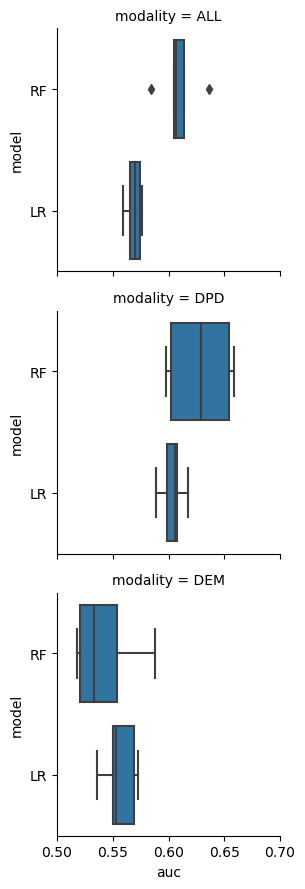

In [14]:
def make_single_row_results(model_dir, row):
    '''
    This function retrieves and summarizes the performance of a specific model from a directory.
    It performs the following steps:

    1. Lists all files in the specified model directory and filters out only the pickle files.
    2. Resets the index of the filtered paths for consistent referencing.
    3. Loads the model from the specified row using the `unpickle()` function.
    4. Extracts the model's file name and its best performance metric (e.g., AUC) from the GridSearchCV results.
    5. Returns a DataFrame containing the model's name and its corresponding performance metric.

    Parameters:
    - model_dir (str): The directory where the model pickle files are stored.
    - row (int): The index of the model in the directory list to retrieve.

    Returns:
    - DataFrame: A DataFrame with a single row containing the model's name and its best performance metric.
    '''
    
    # List all files in the model directory and filter for pickle files
    paths = model_dir + pd.Series(os.listdir(model_dir))
    paths = paths[paths.str.contains(".pkl")]
    paths = paths.reset_index(drop=True)

    # Load the model from the specified row
    study = unpickle(paths[row])

    # Return a DataFrame with the model name and its best score (e.g., AUC)
    return pd.DataFrame(
        {"model": paths[row].split("/")[-1], "metric": study[1].best_score_},
        index=[row],
    )


def make_multiple_row_results(model_dir):
    '''
    This function compiles the performance metrics of all models in a directory into a single DataFrame.
    It performs the following steps:

    1. Initializes an empty DataFrame to store the results.
    2. Iterates through all models in the specified directory (except the first one).
    3. For each model, calls `make_single_row_results()` to retrieve the model's name and best performance metric.
    4. Concatenates the results for each model into the main DataFrame.
    5. Sorts the resulting DataFrame by performance metric in descending order and resets the index.

    Parameters:
    - model_dir (str): The directory where the model pickle files are stored.

    Returns:
    - DataFrame: A DataFrame containing the names and performance metrics of all models, sorted by metric.
    '''
    
    # Initialize an empty DataFrame to store results
    df = pd.DataFrame()

    # Get the number of model files in the directory
    n = len(os.listdir(model_dir))

    # Iterate over each model, except the first file
    for i in range(n - 1):
        # Retrieve and concatenate the results for each model
        df = pd.concat([df, make_single_row_results(model_dir, i)], axis=0)

    # Sort the DataFrame by performance metric and reset the index
    return df.sort_values(by="metric", ascending=False).reset_index(drop=True)


def evaluate_all_models_on_validation_data(model_dir):
    '''
    This function evaluates the performance of all models on validation data and organizes the results for comparison.
    It performs the following steps:

    1. Calls `make_multiple_row_results()` to compile the performance metrics of all models in the directory.
    2. Initializes an empty DataFrame to store the evaluation results.
    3. Iterates through each model type (e.g., dummy, random forest, logistic regression) and modality (e.g., all, demo, dpd).
    4. Filters the compiled metrics DataFrame for each combination of model type, modality, and fold.
    5. Appends the performance results (AUC) for each combination to the evaluation DataFrame.
    6. Returns a DataFrame containing the performance metrics for all models, organized by modality and model type.

    Parameters:
    - model_dir (str): The directory where the model pickle files are stored.

    Returns:
    - DataFrame: A DataFrame containing the performance metrics (AUC) for all models, organized by modality and model type.
    '''
    
    # Compile performance metrics for all models
    df = make_multiple_row_results(model_dir)

    # Define the models and modalities to evaluate
    models = ["dummy", "rf", "lr"]
    modalities = ["all", "demo", "dpd"]

    # Initialize an empty DataFrame to store evaluation results
    performance_validation_sets = pd.DataFrame()

    # Iterate over each model type
    for model in models:
        # Iterate over each modality
        for modality in modalities:
            # Iterate over each fold (assumes 5-fold cross-validation)
            for fold in range(5):
                # Filter the metrics DataFrame for the current combination of model, modality, and fold
                performance_multiple_folds = df[
                    df.model.str.contains(model)
                    & df.model.str.contains(modality)
                    & df.model.str.contains(str(fold))
                ]

                # Append the performance results to the evaluation DataFrame
                performance_validation_sets = pd.concat(
                    [
                        performance_validation_sets,
                        pd.DataFrame(
                            {
                                "modality": modality[:3].upper(),
                                "model": model.upper(),
                                "auc": performance_multiple_folds.metric.values[0],
                            },
                            index=[0],
                        ),
                    ]
                )

    return performance_validation_sets


# Evaluate all models on validation data and organize the results
df = evaluate_all_models_on_validation_data(model_dir)

# Sort the results by modality and model type
df.sort_values(by=["modality", "model"]).reset_index(drop=True)

# Create a FacetGrid for visualizing the AUC scores by modality and model type
g = sns.FacetGrid(data=df, row="modality", row_order=["ALL", "DPD", "DEM"])
g.map(sns.boxplot, "auc", "model", orient="h", order=["RF", "LR"])

# Set the x-axis limits and display the plot
plt.xlim(0.5, 0.7)
plt.show()

## Test set

We evaluate models on hold-out test data. We have 5 train-test splits so we evaluate 5 times and aggregate by taking the median.

In [20]:
def unpickle(file):
    '''
    This function loads a serialized Python object from a pickle file.
    
    Parameters:
    - file (str): The path to the pickle file that contains the serialized object.
    
    Returns:
    - object: The deserialized Python object from the pickle file.
    '''
    
    # Open the file in binary read mode and load the object using pickle
    with open(file, "rb") as f:
        object = pickle.load(f)

    return object


def load_model(path):
    '''
    This function loads a machine learning model from a specified pickle file.

    Parameters:
    - path (str): The path to the pickle file containing the model.

    Returns:
    - model: The loaded machine learning model.
    '''
    return unpickle(path)


def predict_model(processed_data_dir, model_dir, modality, model_type, fold):
    '''
    This function loads a trained model and makes predictions on the test data.
    It performs the following steps:

    1. Loads the test data (features and labels) for the specified fold.
    2. Loads the trained model corresponding to the specified modality, model type, and fold.
    3. Depending on the modality, selects the relevant features from the test data.
    4. Uses the loaded model to make predictions and compute probabilities on the test data.
    5. Returns the true labels, predicted labels, and predicted probabilities.

    Parameters:
    - processed_data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - y_test (DataFrame): The true labels for the test data.
    - y_pred (ndarray): The predicted labels from the model.
    - y_score (ndarray): The predicted probabilities from the model.
    '''
    
    # Load the test features and labels for the specified fold
    X_test = pd.read_csv(processed_data_dir + "X_test_" + str(fold) + ".csv")
    y_test = pd.read_csv(processed_data_dir + "y_test_" + str(fold) + ".csv")

    # Load the trained model
    model = load_model(
        model_dir + model_type + "_" + modality + "_" + str(fold) + ".pkl"
    )

    # Select and predict based on the specified modality
    if modality == "dpd":
        # Exclude demographic features for the "dpd" modality
        X_test = X_test[
            X_test.columns[~X_test.columns.isin(X_test.filter(like="demo").columns)]
        ]
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    elif modality == "all":
        # Use all features for prediction
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    elif modality == "demo":
        # Use only demographic features for prediction
        y_pred = model.predict(X_test.filter(like=modality))
        y_score = model.predict_proba(X_test.filter(like=modality))

    return y_test, y_pred, y_score


def compute_performance(y_test, y_pred, y_score, model_type, modality, fold):
    '''
    This function computes various performance metrics for the model's predictions.
    It calculates metrics such as AUC-ROC, F1 scores, precision, recall, and accuracy.
    
    Parameters:
    - y_test (DataFrame): The true labels for the test data.
    - y_pred (ndarray): The predicted labels from the model.
    - y_score (ndarray): The predicted probabilities from the model.
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - df (DataFrame): A DataFrame containing the computed performance metrics.
    '''
    
    # Calculate various performance metrics
    auc_roc = roc_auc_score(y_test, y_score[:, 1])
    f11 = f1_score(y_test, y_pred, pos_label=1)
    f10 = f1_score(y_test, y_pred, pos_label=0)
    precision1 = precision_score(y_test, y_pred, pos_label=1)
    precision0 = precision_score(y_test, y_pred, pos_label=0)
    recall1 = recall_score(y_test, y_pred, pos_label=1)
    recall0 = recall_score(y_test, y_pred, pos_label=0)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    # Create a DataFrame with the performance metrics
    df = pd.DataFrame(
        {
            "Modality": modality,
            "Fold": fold,
            "Model": model_type,
            "AUC ROC": auc_roc,
            "F10": f10,
            "F11": f11,
            "Precision0": precision0,
            "Precision1": precision1,
            "Recall0": recall0,
            "Recall1": recall1,
            "Accuracy": accuracy
        },
        index=[0],
    )
    return df


def write_predictions_to_file(
    y_test, y_pred, y_score, evaluation_dir, modality, model_type, fold
):
    '''
    This function saves the true labels, predicted labels, and predicted probabilities to CSV files.
    
    Parameters:
    - y_test (DataFrame): The true labels for the test data.
    - y_pred (ndarray): The predicted labels from the model.
    - y_score (ndarray): The predicted probabilities from the model.
    - evaluation_dir (str): The directory where the prediction results will be saved.
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - None: The function saves the predictions to CSV files.
    '''
    
    # Convert the true labels, predicted labels, and predicted scores to DataFrames
    y_test = pd.DataFrame(y_test)
    y_pred = pd.DataFrame(y_pred)
    y_score = pd.DataFrame(y_score)

    # Save the true labels to a CSV file
    y_test.to_csv(
        evaluation_dir
        + "y_test_"
        + modality
        + "_"
        + model_type
        + "_"
        + str(fold)
        + ".csv",
        index=False,
    )
    # Save the predicted labels to a CSV file
    y_pred.to_csv(
        evaluation_dir
        + "y_pred_"
        + modality
        + "_"
        + model_type
        + "_"
        + str(fold)
        + ".csv",
        index=False,
    )
    # Save the predicted probabilities to a CSV file
    y_score.to_csv(
        evaluation_dir
        + "y_pred_"
        + modality
        + "_"
        + model_type
        + "_"
        + str(fold)
        + ".csv",
        index=False,
    )


def get_performance_single_model(model_dir, model_type, modality, data_dir, fold):
    '''
    This function evaluates a single model on test data, computes its performance metrics, and saves the results.
    It performs the following steps:

    1. Calls `predict_model()` to make predictions on the test data.
    2. Saves the true labels, predicted labels, and predicted probabilities to files.
    3. Computes various performance metrics using `compute_performance()`.
    4. Returns the computed performance metrics.

    Parameters:
    - model_dir (str): The directory where the trained model pickle files are stored.
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - data_dir (str): The directory where the processed test data files are stored.
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - performance (DataFrame): A DataFrame containing the computed performance metrics for the model.
    '''
    
    # Predict on the test data
    y_test, y_pred, y_score = predict_model(
        processed_dir, model_dir, modality, model_type, fold
    )

    # Save the predictions to files
    write_predictions_to_file(
        y_test, y_pred, y_score, evaluation_dir, modality, model_type, fold
    )

    # Compute the performance metrics
    performance = compute_performance(
        y_test, y_pred, y_score, model_type, modality, fold
    )
        
    return performance


def get_performance_multiple_models(data_dir, model_dir):
    '''
    This function evaluates multiple models across different folds, modalities, and model types.
    It performs the following steps:

    1. Initializes an empty DataFrame to store the performance metrics.
    2. Iterates over each fold in the cross-validation process.
    3. For each fold, iterates through the different model types (e.g., logistic regression, random forest, dummy classifier).
    4. For each model type, iterates through the different modalities (e.g., all features, demographic features, digital phenotyping features).
    5. Calls `get_performance_single_model()` to evaluate each model on the test data and retrieve performance metrics.
    6. Concatenates the performance metrics of all models into a single DataFrame.
    7. Sorts the DataFrame by modality and model type, and resets the index for clarity.

    Parameters:
    - data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.

    Returns:
    - df (DataFrame): A DataFrame containing the performance metrics for all evaluated models, sorted by modality and model type.
    '''
    
    # Initialize an empty DataFrame to collect performance metrics from all models
    df = pd.DataFrame()

    # Iterate over the cross-validation folds (assumes 5-fold CV)
    for fold in range(5):
        # Iterate over each model type
        for model_type in ["dummy", "lr", "rf"]:
            # Iterate over each modality
            for modality in ["all", "demo", "dpd"]:
                # Evaluate the model and get performance metrics
                performance = get_performance_single_model(
                    model_dir, model_type, modality, data_dir, fold
                )
                # Append the performance metrics to the DataFrame
                df = pd.concat([df, performance], axis=0)
    
    # Sort the DataFrame by modality and model type, then reset the index
    return df.sort_values(by=["Modality", "Model"], ascending=True).reset_index(
        drop=True
    )


# Evaluate all models, group by modality and model type, and compute median performance
df = get_performance_multiple_models(processed_dir, model_dir)

# Group the results by modality and model type, compute median values for performance metrics, and round them to 2 decimal places
df = (
    df.groupby(["Modality", "Model"])
    .aggregate(["median"])
    .round(2)
)

# Reset the index, drop the "Fold" column, and remove the level indicator in the column names
df = df.reset_index().drop(["Fold"], axis=1).droplevel(level=1, axis=1)

# Reorder and select specific rows for the final output, and save to a CSV file
df.iloc[[0, 1, 2, 7, 8, 4, 5], :].to_csv(performance_dir + "model-performance.csv", index=False)

## Model fairness

We assess model fairness by computing the evaluation metrics for (median-split) demographic groups.

In [10]:
def predict_model_subgroup(processed_data_dir, model_dir, modality, model_type, fold, group_var, group_number):
    '''
    This function predicts outcomes for a specific subgroup within the test data using a pre-trained model.
    It performs the following steps:

    1. Loads the test data (features and labels) for the specified fold.
    2. Prepares the demographic data and assigns group labels based on age, education, and sex.
    3. Merges the test data with the demographic information to identify the indices of the selected subgroup.
    4. Filters the test data to include only the selected subgroup.
    5. Loads the trained model corresponding to the specified modality, model type, and fold.
    6. Depending on the modality, selects the relevant features from the test data.
    7. Uses the loaded model to make predictions and compute probabilities for the subgroup.
    8. Returns the true labels, predicted labels, and predicted probabilities for the subgroup.

    Parameters:
    - processed_data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - fold (int): The fold number corresponding to the cross-validation split.
    - group_var (str): The variable used to define the subgroup (e.g., "age_group", "edu_group", "sex_group").
    - group_number (int): The specific group number within the subgroup variable (e.g., 0 or 1).

    Returns:
    - y_test (DataFrame): The true labels for the test data in the selected subgroup.
    - y_pred (ndarray): The predicted labels from the model for the selected subgroup.
    - y_score (ndarray): The predicted probabilities from the model for the selected subgroup.
    '''
    
    # Load the test features and labels for the specified fold
    X_test = pd.read_csv(processed_data_dir + "X_test_" + str(fold) + ".csv")
    y_test = pd.read_csv(processed_data_dir + "y_test_" + str(fold) + ".csv")

    # Prepare the demographic data and assign group labels
    df = make_interim_data(raw_dir, raw_data_paths)
    df['age_group'] = pd.cut(df.demo_age, 2, labels=[0, 1])
    df['edu_group'] = pd.cut(df.demo_edu, 2, labels=[0, 1])
    df['sex_group'] = df.demo_sex

    # Load the IDs for the current fold and merge with demographic data to identify subgroup
    df_id = pd.read_csv(processed_dir + 'id_test_' + str(fold) + '.csv')
    df = pd.merge(df_id, df, on='id')[['id', 'age_group', 'edu_group', 'sex_group']]

    # Select the indices corresponding to the specified subgroup
    selected_indices = df[df[group_var] == group_number].index

    # Filter the test data for the selected subgroup
    X_test = X_test.iloc[selected_indices, :]
    y_test = y_test.iloc[selected_indices, :]

    # Load the trained model for the specified fold, modality, and model type
    model = load_model(
        model_dir + model_type + "_" + modality + "_" + str(fold) + ".pkl"
    )

    # Select and predict based on the specified modality
    if modality == "dpd":
        X_test = X_test[
            X_test.columns[~X_test.columns.isin(X_test.filter(like="demo").columns)]
        ]
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    elif modality == "all":
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    elif modality == "demo":
        y_pred = model.predict(X_test.filter(like=modality))
        y_score = model.predict_proba(X_test.filter(like=modality))

    return y_test, y_pred, y_score


def get_performance_single_model_subgroup(model_dir, model_type, modality, data_dir, fold, group_var, group_number):
    '''
    This function evaluates the performance of a single model on a specific subgroup within the test data.
    It performs the following steps:

    1. Calls `predict_model_subgroup()` to make predictions on the test data for the specified subgroup.
    2. Computes various performance metrics using `compute_performance()`.
    3. Returns the computed performance metrics for the model on the selected subgroup.

    Parameters:
    - model_dir (str): The directory where the trained model pickle files are stored.
    - model_type (str): The type of model used (e.g., "lr", "rf", "dummy").
    - modality (str): The modality or feature set used for prediction (e.g., "demo", "dpd", "all").
    - data_dir (str): The directory where the processed test data files are stored.
    - fold (int): The fold number corresponding to the cross-validation split.
    - group_var (str): The variable used to define the subgroup (e.g., "age_group", "edu_group", "sex_group").
    - group_number (int): The specific group number within the subgroup variable (e.g., 0 or 1).

    Returns:
    - performance (DataFrame): A DataFrame containing the computed performance metrics for the model on the selected subgroup.
    '''
    
    # Predict on the test data for the specified subgroup
    y_test, y_pred, y_score = predict_model_subgroup(
        processed_dir, model_dir, modality, model_type, fold, group_var, group_number
    )

    # Compute the performance metrics for the selected subgroup
    performance = compute_performance(
        y_test, y_pred, y_score, model_type, modality, fold
    )
        
    return performance


def get_performance_multiple_models_subgroup(data_dir, model_dir, group_var, group_number):
    '''
    This function evaluates the performance of multiple models across different folds and modalities for a specific subgroup.
    It performs the following steps:

    1. Initializes an empty DataFrame to store the performance metrics.
    2. Iterates over each fold in the cross-validation process.
    3. For each fold, iterates through the different model types (e.g., logistic regression, random forest, dummy classifier).
    4. For each model type, iterates through the different modalities (e.g., all features, demographic features, digital phenotyping features).
    5. Calls `get_performance_single_model_subgroup()` to evaluate each model on the test data for the specified subgroup and retrieve performance metrics.
    6. Concatenates the performance metrics of all models into a single DataFrame.
    7. Sorts the DataFrame by modality and model type, and resets the index for clarity.

    Parameters:
    - data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - group_var (str): The variable used to define the subgroup (e.g., "age_group", "edu_group", "sex_group").
    - group_number (int): The specific group number within the subgroup variable (e.g., 0 or 1).

    Returns:
    - df (DataFrame): A DataFrame containing the performance metrics for all evaluated models on the specified subgroup, sorted by modality and model type.
    '''
    
    # Initialize an empty DataFrame to collect performance metrics from all models
    df = pd.DataFrame()

    # Iterate over the cross-validation folds (assumes 5-fold CV)
    for fold in range(5):
        # Iterate over each model type
        for model_type in ["dummy", "lr", "rf"]:
            # Iterate over each modality
            for modality in ["all", "demo", "dpd"]:
                # Evaluate the model on the specified subgroup and get performance metrics
                performance = get_performance_single_model_subgroup(
                    model_dir, model_type, modality, data_dir, fold, group_var, group_number
                )
                # Append the performance metrics to the DataFrame
                df = pd.concat([df, performance], axis=0)
    
    # Sort the DataFrame by modality and model type, then reset the index
    return df.sort_values(by=["Modality", "Model"], ascending=True).reset_index(
        drop=True
    )

def get_performance_subgroups(processed_dir, model_dir, group_var, group_number):
    '''
    This function evaluates the performance of multiple models across different folds, modalities, and model types for a specific subgroup.
    It performs the following steps:

    1. Calls `get_performance_multiple_models_subgroup()` to evaluate the performance of multiple models on the selected subgroup.
    2. Groups the results by modality and model type, computes median values for performance metrics, and rounds them to 2 decimal places.
    3. Resets the index, drops the "Fold" column, and saves the final output to a CSV file.

    Parameters:
    - processed_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - group_var (str): The variable used to define the subgroup (e.g., "age_group", "edu_group", "sex_group").
    - group_number (int): The specific group number within the subgroup variable (e.g., 0 or 1).

    Returns:
    - None: The function saves the performance metrics for the subgroup to a CSV file.
    '''
    
    # Evaluate multiple models on the selected subgroup and get performance metrics
    df = get_performance_multiple_models_subgroup(processed_dir, model_dir, group_var, group_number)
    
    # Group the results by modality and model type, compute median values for performance metrics, and round them to 2 decimal places
    df = (
        df.groupby(["Modality", "Model"])
        .aggregate(["median"])
        .round(2)
    )
    
    # Reset the index, drop the "Fold" column, and remove the level indicator in the column names
    df = df.reset_index().drop(["Fold"], axis=1).droplevel(level=1, axis=1)
    
    # Save the performance metrics for the subgroup to a CSV file
    df.iloc[[0, 1, 2, 7, 8, 4, 5], :].to_csv(performance_dir + "model-performance-" + group_var + "-" + str(group_number) + ".csv", index=False)


# Loop over each subgroup variable (age, education, sex) and each group within that variable, and evaluate the models
for group_var in ['age_group', 'edu_group', 'sex_group']:
    for group_number in [0, 1]:
        get_performance_subgroups(processed_dir, model_dir, group_var, group_number)


# Compare performance between subgroups for each variable (age, education, sex) by calculating the performance gap
for group_var in ['age_group', 'edu_group', 'sex_group']:
    # Load the performance metrics for the two groups within the subgroup variable
    df_1 = pd.read_csv(performance_dir + 'model-performance-' + group_var + '-0.csv')
    df_2 = pd.read_csv(performance_dir + 'model-performance-' + group_var + '-1.csv')
    
    # Compute the difference (gap) in performance between the two groups and save to a CSV file
    (df_1.set_index(['Modality', 'Model']) - df_2.set_index(['Modality', 'Model'])).to_csv(performance_dir + 'performance-gap-' + group_var + '.csv')

## Model explanation

We use the SHAP library to explain how our models make predictions. 

In [16]:
def predict_model(model, X_test):
    '''
    This function makes predictions on the test data using a specified model.
    
    Parameters:
    - model (tuple): A tuple where the second element is the trained model (from GridSearchCV).
    - X_test (DataFrame): The test data features.
    
    Returns:
    - ndarray: The predicted labels from the model.
    '''
    return model[1].predict(X_test)


def load_data_and_model(data_dir, model_dir, model_type, modality, fold):
    '''
    This function loads the test data and a pre-trained model for a specific fold, modality, and model type.
    It also formats the feature names for interpretability in SHAP plots.

    Parameters:
    - data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - model_type (str): The type of model used (e.g., "lr", "rf").
    - modality (str): The modality or feature set used for prediction (e.g., "all", "demo", "dpd").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - X_test (DataFrame): The test data features, with formatted column names.
    - model (object): The best estimator from the trained model.
    '''
    
    # Load the test data based on the specified modality
    if modality == "all":
        X_test = pd.read_csv(data_dir + "X_train_" + str(fold) + ".csv")
    elif modality == "demo":
        X_test = pd.read_csv(data_dir + "X_train_" + str(fold) + ".csv").filter(like=modality)
    else:
        X_test = pd.read_csv(data_dir + "X_train_" + str(fold) + ".csv")
        demo_var_names = X_test.filter(like="demo").columns
        X_test = X_test[X_test.columns[~X_test.columns.isin(demo_var_names)]]

    # Load the trained model
    model = load_model(model_dir + model_type + "_" + modality + "_" + str(fold) + ".pkl")

    # Format the feature names for interpretability
    X_test.columns = (
        X_test.columns.str.replace("_", " ")
        .str.replace("location ", "")
        .str.replace("app ", "")
        .str.replace("demo ", "")
        .str.capitalize()
    )

    return X_test, model[1].best_estimator_


def build_explainer(model_type, model, X_test):
    '''
    This function builds a SHAP explainer based on the model type and test data.
    
    Parameters:
    - model_type (str): The type of model used (e.g., "lr", "rf").
    - model (object): The trained model for which explanations are being generated.
    - X_test (DataFrame): The test data features used for generating SHAP values.
    
    Returns:
    - explainer (shap.Explainer): A SHAP explainer object for the given model and data.
    '''
    
    if model_type == "lr":
        explainer = shap.LinearExplainer(model, X_test)
    elif model_type == "rf":
        explainer = shap.TreeExplainer(model, X_test)

    return explainer


def make_beeswarm_plot(model_type, explainer, X_test):
    '''
    This function generates a SHAP beeswarm plot to visualize feature importance.

    Parameters:
    - model_type (str): The type of model used (e.g., "lr", "rf").
    - explainer (shap.Explainer): The SHAP explainer object for the model.
    - X_test (DataFrame): The test data features used for generating SHAP values.
    
    Returns:
    - None: The function generates and displays a SHAP beeswarm plot.
    '''
    
    if model_type == "lr":
        shap_values = explainer(X_test)
        shap.plots.beeswarm(shap_values)
    elif model_type == "rf":
        shap_values = explainer(X_test, check_additivity=False)
        shap.plots.beeswarm(shap_values[:, :, 1])

    plt.clf()


from matplotlib.colors import LinearSegmentedColormap

# Modify the "Purples" colormap for use in SHAP plots
original_cmap = plt.cm.get_cmap("Purples")
colors = original_cmap(np.linspace(0.4, 1, 256))
new_cmap = LinearSegmentedColormap.from_list("ModifiedPurples", colors)


def save_beeswarm_plot(
    data_dir, model_dir, figure_dir, model_type, explainer, X_test, modality, fold
):
    '''
    This function generates and saves a SHAP beeswarm plot to a file.

    Parameters:
    - data_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - figure_dir (str): The directory where the SHAP plots will be saved.
    - model_type (str): The type of model used (e.g., "lr", "rf").
    - explainer (shap.Explainer): The SHAP explainer object for the model.
    - X_test (DataFrame): The test data features used for generating SHAP values.
    - modality (str): The modality or feature set used for prediction (e.g., "all", "demo", "dpd").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - None: The function saves a SHAP beeswarm plot as a PNG file.
    '''
    
    if model_type == "lr":
        shap_values = explainer(X_test)
        shap.plots.beeswarm(
            shap_values, show=False, max_display=20, axis_color="black", color=new_cmap
        )
    elif model_type == "rf":
        shap_values = explainer(X_test, check_additivity=False)
        shap.plots.beeswarm(
            shap_values[:, :, 1],
            show=False,
            max_display=200,
            axis_color="black",
            color=new_cmap,
        )

    plt.tight_layout()
    plt.savefig(
        figure_dir
        + "beeswarm_"
        + model_type
        + "_"
        + modality
        + "_"
        + str(fold)
        + ".png"
    )
    plt.clf()


def make_beeswarm_plot(
    processed_dir, model_dir, figure_dir, model_type, modality, fold
):
    '''
    This function coordinates the loading of data and model, building of the SHAP explainer, 
    and saving of the SHAP beeswarm plot for a specific fold, modality, and model type.

    Parameters:
    - processed_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - figure_dir (str): The directory where the SHAP plots will be saved.
    - model_type (str): The type of model used (e.g., "lr", "rf").
    - modality (str): The modality or feature set used for prediction (e.g., "all", "demo", "dpd").
    - fold (int): The fold number corresponding to the cross-validation split.

    Returns:
    - None: The function saves a SHAP beeswarm plot as a PNG file.
    '''
    
    X_test, model = load_data_and_model(
        processed_dir, model_dir, model_type, modality, fold
    )

    explainer = build_explainer(model_type, model, X_test)

    save_beeswarm_plot(
        processed_dir,
        model_dir,
        figure_dir,
        model_type,
        explainer,
        X_test,
        modality,
        fold,
    )


def explain_multiple_models(processed_dir, model_dir, figure_dir):
    '''
    This function generates and saves SHAP beeswarm plots for multiple models across different folds and modalities.
    
    Parameters:
    - processed_dir (str): The directory where the processed test data files are stored.
    - model_dir (str): The directory where the trained model pickle files are stored.
    - figure_dir (str): The directory where the SHAP plots will be saved.

    Returns:
    - None: The function saves multiple SHAP beeswarm plots as PNG files.
    '''
    
    for model_type in ["lr", "rf"]:
        for modality in ["all", "demo", "dpd"]:
            for fold in range(5):
                make_beeswarm_plot(
                    processed_dir, model_dir, figure_dir, model_type, modality, fold
                )


# Run the function to generate and save SHAP beeswarm plots for all models
explain_multiple_models(processed_dir, model_dir, figure_dir)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Param

<Figure size 800x190 with 0 Axes>